# BigEarthNet Analysis

## Data Preparation

In [17]:
import torch
import rasterio
import kornia as K
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import umap
import umap.plot
from torchgeo.datasets import BigEarthNet
from torch.utils.data import DataLoader

In [18]:
# vh,vv
S1_MEAN = [166.36275909, 88.45542715]# / 255.0
S1_STD = [64.83126309, 43.07350145]# /255.0

S2_MEAN = [114.1099739 , 114.81779093, 126.63977424,  84.33539309,
        97.84789168, 103.94461911, 101.435633  ,  72.32804172,
        56.66528851]
S2_STD = [77.84352553, 69.96844919, 67.42465279, 64.57022983, 61.72545487,
       61.34187099, 60.29744676, 47.88519516, 42.55886798]

class DataAugmentation(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.transform = torch.nn.Sequential(
            K.augmentation.RandomResizedCrop(size=(224,224), scale=(0.2,1.0)),
            K.augmentation.Normalize(mean=mean,std=std)
        )
    @torch.no_grad()
    def forward(self,x):
        x_out = self.transform(x)
        return x_out
    
transform = DataAugmentation(mean=S1_MEAN,std=S1_STD)

## Model loading

In [19]:
from models_dwv import vit_large_patch16
from models_dwv import vit_base_patch16

large = True

if large:
    check_point = torch.load('./checkpoints/DOFA_ViT_large_e100.pth')
    vit_model = vit_large_patch16()
else:
    check_point = torch.load('./checkpoints/DOFA_ViT_base_e100.pth')
    vit_model = vit_base_patch16()
vit_model = vit_model.cuda()
vit_model.eval()
msg = vit_model.load_state_dict(check_point, strict=False)
# missing_keys=['fc_norm.weight', 'fc_norm.bias', 'head.weight', 'head.bias'], unexpected_keys=['mask_token', 'norm.weight', 'norm.bias', 'projector.weight', 'projector.bias']

## Running model on images

In [20]:
dataset_path = "data/bigearthnet/"

In [21]:
dataset = BigEarthNet(
    root=dataset_path,
    split="train",  # or "val", "test"
    bands="s1",
    num_classes=43,  # or 19 depending on the task
    download=False,
    checksum=False
)

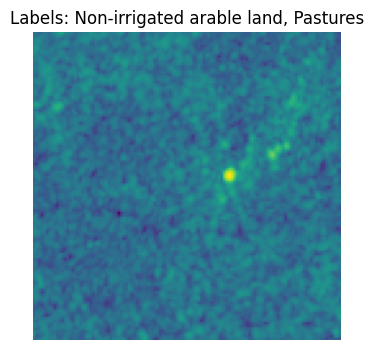

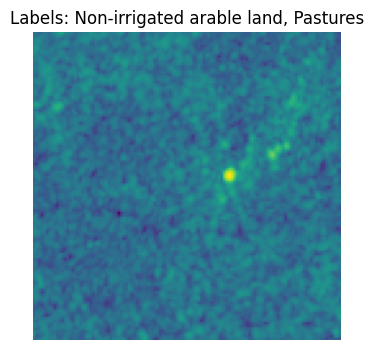

In [22]:
dataset.plot(dataset.__getitem__(2000))

In [23]:
BATCH_SIZE = 32

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=8
)
len(dataloader)
len(dataset)

269695

In [24]:
len(dataset)//BATCH_SIZE

8427

In [25]:
C = 2  # can be 2,3,4,6,9,12,13,202 or any number if you can provide the wavelengths of them
tensor_size = 1024 if large else 768
wavelengths = [3.75, 3.75]
tensor_size = 1024 if large else 768
out_feat = torch.zeros(len(dataset), tensor_size)
out_logits = torch.zeros(len(dataset),  45)
save_labels = torch.zeros(len(dataset), 43)

with torch.no_grad():
    for index, batch in enumerate(tqdm(dataloader)):
        images = batch["image"]
        labels = batch["label"]
        preprocessed_images = transform(images)
        preprocessed_images = preprocessed_images.to('cuda')
        pos = index * BATCH_SIZE
        size = preprocessed_images.shape[0]
        out_feat[pos:pos+size] = vit_model.forward_features(preprocessed_images, wave_list=wavelengths).to('cpu')
        out_logits[pos:pos+size] = vit_model.forward(preprocessed_images, wave_list=wavelengths).to('cpu')
        save_labels[pos:pos+size] = labels
        del preprocessed_images

100%|██████████| 8428/8428 [1:49:13<00:00,  1.29it/s]


In [26]:
suffix = "large" if large else "base"
torch.save(out_logits, f'./features/s1-logits-train-bigearthnet-v1-{suffix}.pth')
torch.save(out_feat, f'./features/s1-feat-train-bigearthnet-v1-{suffix}.pth')
torch.save(save_labels, f'./features/s1-labels-train-bigearthnet-v1-{suffix}.pth')

In [27]:
test_dataset = BigEarthNet(
    root=dataset_path,
    split="test",  # or "val", "test"
    bands="s1",
    num_classes=43,  # or 19 depending on the task
    download=False,
    checksum=False
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=8
)
print(len(test_dataset))
len(test_dataloader)

125866


3934

In [28]:
tensor_size = 1024 if large else 768
out_test_feat = torch.zeros(len(test_dataset), tensor_size)
out_test_logits = torch.zeros(len(test_dataset),  45)
save_test_labels = torch.zeros(len(test_dataset), 43)

with torch.no_grad():
    for index, batch in enumerate(tqdm(test_dataloader)):
        images = batch["image"]
        labels = batch["label"]
        preprocessed_images = transform(images)
        preprocessed_images = preprocessed_images.to('cuda')
        pos = index * BATCH_SIZE
        size = preprocessed_images.shape[0]
        out_test_feat[pos:pos+size] = vit_model.forward_features(preprocessed_images, wave_list=wavelengths).to('cpu')
        out_test_logits[pos:pos+size] = vit_model.forward(preprocessed_images, wave_list=wavelengths).to('cpu')
        save_test_labels[pos:pos+size] = labels
        del preprocessed_images

100%|██████████| 3934/3934 [50:10<00:00,  1.31it/s]


In [29]:
suffix = "large" if large else "base"
torch.save(out_test_logits, f'./features/s1-logits-test-bigearthnet-v1-{suffix}.pth')
torch.save(out_test_feat, f'./features/s1-feat-test-bigearthnet-v1-{suffix}.pth')
torch.save(save_test_labels, f'./features/s1-labels-test-bigearthnet-v1-{suffix}.pth')

In [30]:
val_dataset = BigEarthNet(
    root=dataset_path,
    split="val",
    bands="s1",
    num_classes=43,  # or 19 depending on the task
    download=False,
    checksum=False
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    num_workers=8
)
print(len(val_dataloader))
print(len(val_dataset))

3867
123723


In [31]:
tensor_size = 1024 if large else 768
out_val_feat = torch.zeros(len(val_dataset), tensor_size)
out_val_logits = torch.zeros(len(val_dataset),  45)
save_val_labels = torch.zeros(len(val_dataset), 43)

with torch.no_grad():
    for index, batch in enumerate(tqdm(val_dataloader)):
        images = batch["image"]
        labels = batch["label"]
        preprocessed_images = transform(images)
        preprocessed_images = preprocessed_images.to('cuda')
        pos = index * BATCH_SIZE
        size = preprocessed_images.shape[0]
        out_val_feat[pos:pos+size] = vit_model.forward_features(preprocessed_images, wave_list=wavelengths).to('cpu')
        out_val_logits[pos:pos+size] = vit_model.forward(preprocessed_images, wave_list=wavelengths).to('cpu')
        save_val_labels[pos:pos+size] = labels
        del preprocessed_images

100%|██████████| 3867/3867 [49:23<00:00,  1.30it/s]


In [32]:
suffix = "large" if large else "base"
torch.save(out_val_logits, f'./features/s1-logits-val-bigearthnet-v1-{suffix}.pth')
torch.save(out_val_feat, f'./features/s1-feat-val-bigearthnet-v1-{suffix}.pth')
torch.save(save_val_labels, f'./features/s1-labels-val-bigearthnet-v1-{suffix}.pth')